In [20]:
import pandas as pd
import numpy as np
from obfuscator import comment_remover, variable_renamer
from csv_stuff import create_labled_table_routine, add_valid_code_columns, remove_given_code
import sys
# sys.path.append('/home/erik/TU/ni/Source-Code-Plagiarism-Detection/Source codes/')
sys.path.append('../../../Source-Code-Plagiarism-Detection/Source codes/')
from remove_given_code_from_student_solution import remove_given_code_from_df


PATH_TEMPLATE = "/home/erik/TU/ni/plagiate_labeltool/data/code_templates/"


def create_plagiate_table(df, semester, ha, task, prog_language, number_labled_pairs, path):
    df_labled = pd.DataFrame(columns=['semester', 'ha', 'task', 'prog_lang',
                                      'surname1', 'lastname1', 'code1', 'code2', 'label'])

    df = add_valid_code_columns(df, semester, ha, [task], prog_language)
    number_of_valid_codes = len(df.loc[df[f'{task} empty'] == 0])
    print("number_of_valid_codes: " + str(number_of_valid_codes))
    plagiate_per_solution = int(np.floor(number_labled_pairs/number_of_valid_codes))
    print("plagiate_per_solution: " + str(plagiate_per_solution))
    for ln, sn, code in df.loc[df[f'{task} empty'] == 0][['Nachname', 'Vorname', task]].values:
        for i in range(plagiate_per_solution):
            plagiate_code = comment_remover(code)
            plagiate_code = variable_renamer(plagiate_code)
            df_labled.loc[len(df_labled)] = [
                semester, ha, task, prog_language, sn, ln, code, plagiate_code, 1]
    df_labled.to_csv(path)
    return df_labled


def create_plagiate_table_routine(semester, ha, task, prog_language):
    csv_path = f'../../data/raw_data/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten.csv'
    csv_path1 = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_removed_preload.csv'
    # csv_path1 = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_labled.csv'
    csv_path2 = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_plagiate.csv'
    df = pd.read_csv(csv_path, delimiter=',')
    number_labled_pairs = len(pd.read_csv(csv_path1, delimiter=','))
    df_labled = create_plagiate_table(
        df, semester, ha, task, prog_language, number_labled_pairs, csv_path2)
    return df_labled


def create_plagiate_table_from_df(df, semester, ha, prog_language):
    save_path = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_plagiate.csv'
    number_labled_pairs = len(df)
    df = df.drop_duplicates(subset=['surname1'])
    number_of_valid_codes = len(df)
    print("number_of_valid_codes: " + str(number_of_valid_codes))
    print("number_labled_pairs: " + str(number_labled_pairs))
    plagiate_per_solution = int(np.floor(number_labled_pairs/number_of_valid_codes))
    print("plagiate_per_solution: " + str(plagiate_per_solution))
    # drop unnecessary columns
    df = df.drop(columns=['hand_labled', 'Unnamed: 0', 'surname2', 'lastname2'])
    # duplicate each row of df1 plagiate_per_solution times and create new column code2 and use the field code1 as input value for the functions comment_remover and variable_renamer
    df = df.reindex(df.index.repeat(plagiate_per_solution))
    df['code2'] = df['code1'].apply(comment_remover)
    df['code2'] = df['code2'].apply(variable_renamer)
    df['label'] = 1
    df.to_csv(save_path)
    return df


def split_data_from_labled(semester, ha, prog_language):
    df_labled = pd.read_csv(f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_labled.csv', delimiter=',')
    df_labled = remove_given_code_from_df(df_labled)
    df_plagiate = create_plagiate_table_from_df(df_labled, semester, ha, prog_language)
    return df_plagiate
    

def open_csvs(semester, ha, prog_language):
    original_csv_path = f'../../data/raw_data/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten.csv'
    labled_csv_path = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_removed_preload.csv'
    plagiate_csv_path = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_plagiate.csv'
    df_original = pd.read_csv(original_csv_path, delimiter=',')
    df_labled = pd.read_csv(labled_csv_path, delimiter=',')
    return df_original, df_labled, plagiate_csv_path


In [21]:
semester='SoSe22'
ha='9'
task='Antwort 9'
prog_language='C'
# path = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_plagiate.csv'
path = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_labled_angefangen.csv'

In [22]:
# df_plagiate = split_data_from_labled(semester, ha, prog_language)

Index(['semester', 'ha', 'task', 'prog_lang', 'surname1', 'lastname1',
       'surname2', 'lastname2', 'code1', 'code2', 'label', 'hand_labled'],
      dtype='object')
0.5196301884602565


<AxesSubplot: >

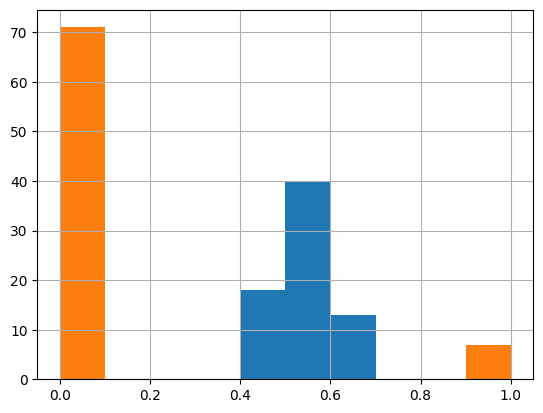

In [23]:
def remove_specific_students(df_labled, names):
    for name in names:
        df_labled = df_labled.drop(df_labled[(df_labled['lastname1'] == name) | (df_labled['lastname2'] == name)].index)
    return df_labled


df_labled = pd.read_csv(path)
try:
    df_labled = df_labled.drop(columns=['Unnamed: 0'])
except KeyError:
    pass
print(df_labled.columns)
names = ['Lehmann', 'Hengst', 'Hilger', 'Krause']
df_labled = remove_specific_students(df_labled, names)

print(df_labled['label'].mean())
df_labled['label'].hist()
df_labled['hand_labled'].hist()
# df_labled.to_csv(path, index=False)
# vorgabe entfernen, auto labeln lassen und dann plagiate erstellen

In [8]:
import re
def striphtml(data): 
    return re.sub('<.*?>', ' ', str(data)) 

def stripunc(data): 
    return re.sub('[^A-Za-z%\._\[\]]+', ' ', str(data), flags=re.MULTILINE|re.DOTALL) 

In [9]:
# # for prasentation to show example strip
# read_path='/home/erik/TU/ni/plagiarism_detection_tool/data/labled/handmade_plagiate_0_0.c'
# write_path='/home/erik/TU/ni/plagiarism_detection_tool/data/labled/handmade_plagiate_0_3.c'
# with open(read_path, 'r') as file:
#     code = file.read()
#     code = striphtml(stripunc(code))
#     with open(write_path, 'w') as file:
#         file.write(code)


# Plagiate maker with pycparser

In [18]:
from pycparser import c_generator, c_parser
import pycparser

# Parse C code
c_code = '''
int main() {
    int a = 1;
    int b = 2;
    int c = a + b;
    return c;
}
'''
# store the code in a file
with open('test.c', 'w') as f:
    f.write(c_code)
    f.close()
ast=pycparser.parse_file('test.c')
# generate Plagiat from AST
import random
import string

def generate_plagiat(ast, n):
    '''Generate n new plagiat based on AST'''
    plagiat = []
    variables = []
    for i in range(n):
        # replace variable names
        for node in ast.ext:
            if isinstance(node, pycparser.c_ast.FuncDef):
                for stmt in node.body.block_items:
                    if isinstance(stmt, pycparser.c_ast.Decl):
                        variables.append(stmt.type.declname)
                        stmt.type.declname = ''.join(random.choices(string.ascii_lowercase, k=5))
                    # print(stmt)


        # replace variable names in expressions
        for node in ast.ext:
            if isinstance(node, pycparser.c_ast.FuncDef):
                for stmt in node.body.block_items:
                    if isinstance(stmt, pycparser.c_ast.BinaryOp):
                        for var in variables:
                            if var in stmt.left.name:
                                stmt.left.name = ''.join(random.choices(string.ascii_lowercase, k=5))
                            if var in stmt.right.name:
                                stmt.right.name = ''.join(random.choices(string.ascii_lowercase, k=5))

        # change function names
        for node in ast.ext:
            if isinstance(node, pycparser.c_ast.FuncDef):
                node.decl.name = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
                node.decl.type.type.declname = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
                
        # ast to string

        code= c_generator.CGenerator().visit(ast)
        plagiat.append(code)
    return plagiat

        
plagiat = generate_plagiat(ast, 5)
# print(ast)
# for p in ast:
#     print(p)
print(c_generator.CGenerator().visit(ast))

int PKW24()
{
  int jkjlk = 1;
  int cqhjd = 2;
  int ryguu = a + b;
  return c;
}


